# Expedia Hotel Recommender System- Wide and Deep

## Importing all libraries

In [224]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
import warnings
import math
from math import sqrt

from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense

import sys
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

from deepctr.layers.core import PredictionLayer, DNN
from deepctr.layers.utils import add_func
from deepctr.models import WDL

from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, DenseFeat,get_feature_names

# Reading and Storing Data

In [159]:
df = pd.read_csv("..\data\\train.csv", sep=',', nrows=150000)
df.shape

(150000, 24)

In [160]:
df.head(2)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1


In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date_time                  150000 non-null  object 
 1   site_name                  150000 non-null  int64  
 2   posa_continent             150000 non-null  int64  
 3   user_location_country      150000 non-null  int64  
 4   user_location_region       150000 non-null  int64  
 5   user_location_city         150000 non-null  int64  
 6   orig_destination_distance  97558 non-null   float64
 7   user_id                    150000 non-null  int64  
 8   is_mobile                  150000 non-null  int64  
 9   is_package                 150000 non-null  int64  
 10  channel                    150000 non-null  int64  
 11  srch_ci                    149875 non-null  object 
 12  srch_co                    149875 non-null  object 
 13  srch_adults_cnt            15

In [162]:
# extract month from date_time
df['checkin_month'] = pd.DatetimeIndex(df['srch_ci']).month
df['checkout_month'] = pd.DatetimeIndex(df['srch_co']).month
df['click_month'] = pd.DatetimeIndex(df['date_time']).month

In [163]:
df= df.drop(['date_time'],axis=1)
df= df.drop(['srch_ci'],axis=1)
df= df.drop(['srch_co'],axis=1)
df= df.drop(['orig_destination_distance'],axis=1)

In [164]:
# rename columns
df = df.rename(columns={'hotel_cluster': 'item_id', 'is_booking': 'rating'})

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   site_name                 150000 non-null  int64  
 1   posa_continent            150000 non-null  int64  
 2   user_location_country     150000 non-null  int64  
 3   user_location_region      150000 non-null  int64  
 4   user_location_city        150000 non-null  int64  
 5   user_id                   150000 non-null  int64  
 6   is_mobile                 150000 non-null  int64  
 7   is_package                150000 non-null  int64  
 8   channel                   150000 non-null  int64  
 9   srch_adults_cnt           150000 non-null  int64  
 10  srch_children_cnt         150000 non-null  int64  
 11  srch_rm_cnt               150000 non-null  int64  
 12  srch_destination_id       150000 non-null  int64  
 13  srch_destination_type_id  150000 non-null  i

### Sparse Features/ Categorical features

In [165]:
# categ_sparse 
sparse_features = ['site_name','posa_continent','user_location_country','user_location_region','user_location_city',
             'user_id','is_mobile','is_package','channel','click_month','checkin_month','checkout_month',
            'srch_adults_cnt','srch_children_cnt','srch_rm_cnt','srch_destination_id','hotel_continent',
               'hotel_country','cnt','click_month', 'checkin_month','checkout_month']

### Dense Features/ Continuous Features

In [166]:
dense_features = ['hotel_market']

### Target Features

In [167]:
target = ['rating']

## Simple preprocessing

Usually we have two methods to encode the sparse categorical feature for embedding

**Label Encoding: map the features to integer value from 0 ~ len(#unique) - 1 

In [168]:
# Label Encoding for sparse features,and normalization for dense numerical features
for feat in sparse_features:
    lbe = LabelEncoder()
    df[feat] = lbe.fit_transform(df[feat])

### Here we use normalization

In [169]:
mms = MinMaxScaler(feature_range=(0,1))
df[dense_features] = mms.fit_transform(df[dense_features])

## Generate feature columns

For sparse features, we transform them into dense vectors by embedding techniques. For dense numerical features, we concatenate them to the input tensors of fully connected layer.

**Label Encoding and Generate feature columns

In [170]:
fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=df[feat].nunique(),embedding_dim=4)
                       for i,feat in enumerate(sparse_features)] + [DenseFeat(feat, 1,)
                      for feat in dense_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

## Generate the training samples and train the model

In [171]:
train, test = train_test_split(df, test_size=0.2)

train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}

## Define Model and train the model

In [172]:
#linear_feature_columns: An iterable containing all the features used by linear part of the model.

model = WDL(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(128, 128), l2_reg_linear=1e-05,
        l2_reg_embedding=1e-05, l2_reg_dnn=0, seed=1024, dnn_dropout=0, dnn_activation='relu',
        task='binary')


model.compile("adam", "mse",metrics=['mse'])

In [173]:
history = model.fit(train_model_input, train[target].values,
                        batch_size=256, epochs=10, verbose=2, validation_split=0.2, )

Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 4s - loss: 0.0778 - mse: 0.0775 - val_loss: 0.0698 - val_mse: 0.0693
Epoch 2/10
375/375 - 2s - loss: 0.0668 - mse: 0.0660 - val_loss: 0.0716 - val_mse: 0.0707
Epoch 3/10
375/375 - 3s - loss: 0.0643 - mse: 0.0631 - val_loss: 0.0736 - val_mse: 0.0723
Epoch 4/10
375/375 - 3s - loss: 0.0624 - mse: 0.0611 - val_loss: 0.0759 - val_mse: 0.0743
Epoch 5/10
375/375 - 3s - loss: 0.0612 - mse: 0.0596 - val_loss: 0.0779 - val_mse: 0.0762
Epoch 6/10
375/375 - 3s - loss: 0.0603 - mse: 0.0586 - val_loss: 0.0794 - val_mse: 0.0776
Epoch 7/10
375/375 - 3s - loss: 0.0595 - mse: 0.0577 - val_loss: 0.0813 - val_mse: 0.0795
Epoch 8/10
375/375 - 3s - loss: 0.0588 - mse: 0.0569 - val_loss: 0.0809 - val_mse: 0.0790
Epoch 9/10
375/375 - 3s - loss: 0.0582 - mse: 0.0563 - val_loss: 0.0833 - val_mse: 0.0813
Epoch 10/10
375/375 - 3s - loss: 0.0574 - mse: 0.0554 - val_loss: 0.0840 - val_mse: 0.0820


In [174]:
#model prediction
pred_result = model.predict(test_model_input, batch_size=256)

In [175]:
auc = roc_auc_score(test[target].values, pred_result)

print("RMSE:\t%f" % np.round(math.sqrt(mean_squared_error(test[target].values, pred_result)),3),"MAE:\t%f" % np.round(mean_absolute_error(test[target].values, pred_result),3),
      "MSE:\t%f" % np.round(mean_squared_error(test[target].values, pred_result),3),"AUC:\t%f" % np.round(auc,3),sep='\n')

RMSE:	0.284000
MAE:	0.126000
MSE:	0.081000
AUC:	0.752000


## Let's Experiments on Hyper-parameters tuning and see their effect on model 

### Instantiates the Wide&Deep Learning architecture.

#### Parameters:	

linear_feature_columns – An iterable containing all the features used by linear part of the model.

dnn_feature_columns – An iterable containing all the features used by deep part of the model.

dnn_hidden_units – list,list of positive integer or empty list, the layer number and units in each layer of DNN

l2_reg_linear – float. L2 regularizer strength applied to wide part

l2_reg_embedding – float. L2 regularizer strength applied to embedding vector

l2_reg_dnn – float. L2 regularizer strength applied to DNN

seed – integer ,to use as random seed.

dnn_dropout – float in [0,1), the probability we will drop out a given DNN coordinate.

dnn_activation – Activation function to use in DNN

task – str, "binary" for binary logloss or "regression" for regression loss

### Tuning Hyperparameters with GridSearch

Grid search, which is an optimization scheme trying all possible combinations of specified hyperparameter choices.

In [176]:
param_grid = {'dnn_hidden_units' : [(1,1),(2,2),(3,3),(8,8),(17,17),(128,128),(256,256)],
              'l2_reg_linear':[1e-05,1e-3,.1, 1, 10],
              'l2_reg_embedding':[1e-7,1e-5,1e-3,1e-1,1],
              'l2_reg_dnn':[0,0.2,2,4],
              'dnn_dropout':np.arange(0, 1, .1)
             }
result = {}

### dnn_hidden_units – list,list of positive integer or empty list, the layer number and units in each layer of DNN

In [177]:
dnn_hidden_units_dict = {}
for i in param_grid['dnn_hidden_units']:
    model = WDL(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=i, 
              seed=1024,task='binary')

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
    
    #model prediction
    pred_result = model.predict(test_model_input, batch_size=256)
    
    #model evaluation RMSE, MAE,MSE
    auc = roc_auc_score(test[target].values, pred_result)
    dnn_hidden_units_dict[i]={"RMSE": np.round(math.sqrt(mean_squared_error(test[target].values, pred_result)),3),
      "MAE" : np.round(mean_absolute_error(test[target].values, pred_result),3),
      "MSE" : np.round(mean_squared_error(test[target].values, pred_result),3),
      "AUC" : np.round(auc,3)}
result['dnn_hidden_units_dict']=dnn_hidden_units_dict

Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.0911 - mse: 0.0910 - val_loss: 0.0755 - val_mse: 0.0754
Epoch 2/10
375/375 - 2s - loss: 0.0748 - mse: 0.0747 - val_loss: 0.0743 - val_mse: 0.0741
Epoch 3/10
375/375 - 2s - loss: 0.0734 - mse: 0.0732 - val_loss: 0.0733 - val_mse: 0.0730
Epoch 4/10
375/375 - 2s - loss: 0.0722 - mse: 0.0719 - val_loss: 0.0726 - val_mse: 0.0721
Epoch 5/10
375/375 - 2s - loss: 0.0713 - mse: 0.0708 - val_loss: 0.0721 - val_mse: 0.0715
Epoch 6/10
375/375 - 2s - loss: 0.0706 - mse: 0.0699 - val_loss: 0.0719 - val_mse: 0.0711
Epoch 7/10
375/375 - 2s - loss: 0.0701 - mse: 0.0692 - val_loss: 0.0717 - val_mse: 0.0708
Epoch 8/10
375/375 - 2s - loss: 0.0697 - mse: 0.0687 - val_loss: 0.0717 - val_mse: 0.0706
Epoch 9/10
375/375 - 2s - loss: 0.0694 - mse: 0.0683 - val_loss: 0.0717 - val_mse: 0.0705
Epoch 10/10
375/375 - 2s - loss: 0.0692 - mse: 0.0679 - val_loss: 0.0717 - val_mse: 0.0704
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 5s - loss: 0.0880 - mse: 0.0878 - val_loss: 0.0749 - val_mse: 0.0746
Epoch 2/10
375/375 - 2s - loss: 0.0729 - mse: 0.0724 - val_loss: 0.0714 - val_mse: 0.0707
Epoch 3/10
375/375 - 2s - loss: 0.0693 - mse: 0.0682 - val_loss: 0.0709 - val_mse: 0.0696
Epoch 4/10
375/375 - 2s - loss: 0.0669 - mse: 0.0654 - val_loss: 0.0719 - val_mse: 0.0702
Epoch 5/10
375/375 - 2s - loss: 0.0652 - mse: 0.0634 - val_loss: 0.0735 - val_mse: 0.0716
Epoch 6/10
375/375 - 2s - loss: 0.0639 - mse: 0.0620 - val_loss: 0.0749 - val_mse: 0.0729
Epoch 7/10
375/375 - 2s - loss: 0.0627 - mse: 0.0607 - val_loss: 0.0762 - val_mse: 0.0741
Epoch 8/10
375/375 - 2s - loss: 0.0618 - mse: 0.0597 - val_loss: 0.0773 - val_mse: 0.0752
Epoch 9/10
375/375 - 2s - loss: 0.0611 - mse: 0.0589 - val_loss: 0.0800 - val_mse: 0.0778
Epoch 10/10
375/375 - 2s - loss: 0.0604 - mse: 0.0582 - val_loss: 0.0795 - val_mse: 0.0773
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 4s - loss: 0.0881 - mse: 0.0879 - val_loss: 0.0745 - val_mse: 0.0742
Epoch 2/10
375/375 - 2s - loss: 0.0712 - mse: 0.0705 - val_loss: 0.0707 - val_mse: 0.0696
Epoch 3/10
375/375 - 2s - loss: 0.0669 - mse: 0.0657 - val_loss: 0.0720 - val_mse: 0.0706
Epoch 4/10
375/375 - 2s - loss: 0.0649 - mse: 0.0633 - val_loss: 0.0737 - val_mse: 0.0720
Epoch 5/10
375/375 - 2s - loss: 0.0634 - mse: 0.0616 - val_loss: 0.0755 - val_mse: 0.0736
Epoch 6/10
375/375 - 2s - loss: 0.0623 - mse: 0.0603 - val_loss: 0.0769 - val_mse: 0.0750
Epoch 7/10
375/375 - 2s - loss: 0.0613 - mse: 0.0593 - val_loss: 0.0784 - val_mse: 0.0764
Epoch 8/10
375/375 - 2s - loss: 0.0606 - mse: 0.0585 - val_loss: 0.0798 - val_mse: 0.0777
Epoch 9/10
375/375 - 2s - loss: 0.0600 - mse: 0.0579 - val_loss: 0.0801 - val_mse: 0.0779
Epoch 10/10
375/375 - 2s - loss: 0.0595 - mse: 0.0574 - val_loss: 0.0821 - val_mse: 0.0799
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 4s - loss: 0.0880 - mse: 0.0879 - val_loss: 0.0718 - val_mse: 0.0714
Epoch 2/10
375/375 - 2s - loss: 0.0694 - mse: 0.0685 - val_loss: 0.0706 - val_mse: 0.0694
Epoch 3/10
375/375 - 3s - loss: 0.0661 - mse: 0.0647 - val_loss: 0.0730 - val_mse: 0.0715
Epoch 4/10
375/375 - 2s - loss: 0.0643 - mse: 0.0626 - val_loss: 0.0742 - val_mse: 0.0725
Epoch 5/10
375/375 - 2s - loss: 0.0628 - mse: 0.0610 - val_loss: 0.0766 - val_mse: 0.0747
Epoch 6/10
375/375 - 2s - loss: 0.0617 - mse: 0.0598 - val_loss: 0.0780 - val_mse: 0.0760
Epoch 7/10
375/375 - 2s - loss: 0.0608 - mse: 0.0588 - val_loss: 0.0786 - val_mse: 0.0765
Epoch 8/10
375/375 - 3s - loss: 0.0603 - mse: 0.0582 - val_loss: 0.0801 - val_mse: 0.0780
Epoch 9/10
375/375 - 2s - loss: 0.0597 - mse: 0.0575 - val_loss: 0.0819 - val_mse: 0.0797
Epoch 10/10
375/375 - 2s - loss: 0.0592 - mse: 0.0570 - val_loss: 0.0820 - val_mse: 0.0798
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.0847 - mse: 0.0845 - val_loss: 0.0703 - val_mse: 0.0697
Epoch 2/10
375/375 - 3s - loss: 0.0682 - mse: 0.0673 - val_loss: 0.0713 - val_mse: 0.0702
Epoch 3/10
375/375 - 2s - loss: 0.0652 - mse: 0.0640 - val_loss: 0.0730 - val_mse: 0.0716
Epoch 4/10
375/375 - 2s - loss: 0.0633 - mse: 0.0618 - val_loss: 0.0750 - val_mse: 0.0734
Epoch 5/10
375/375 - 2s - loss: 0.0620 - mse: 0.0603 - val_loss: 0.0763 - val_mse: 0.0746
Epoch 6/10
375/375 - 2s - loss: 0.0609 - mse: 0.0591 - val_loss: 0.0780 - val_mse: 0.0762
Epoch 7/10
375/375 - 2s - loss: 0.0601 - mse: 0.0583 - val_loss: 0.0803 - val_mse: 0.0784
Epoch 8/10
375/375 - 2s - loss: 0.0594 - mse: 0.0575 - val_loss: 0.0817 - val_mse: 0.0798
Epoch 9/10
375/375 - 2s - loss: 0.0589 - mse: 0.0569 - val_loss: 0.0815 - val_mse: 0.0795
Epoch 10/10
375/375 - 2s - loss: 0.0584 - mse: 0.0564 - val_loss: 0.0844 - val_mse: 0.0824
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 4s - loss: 0.0775 - mse: 0.0772 - val_loss: 0.0697 - val_mse: 0.0692
Epoch 2/10
375/375 - 2s - loss: 0.0667 - mse: 0.0659 - val_loss: 0.0720 - val_mse: 0.0711
Epoch 3/10
375/375 - 3s - loss: 0.0641 - mse: 0.0631 - val_loss: 0.0735 - val_mse: 0.0722
Epoch 4/10
375/375 - 3s - loss: 0.0623 - mse: 0.0610 - val_loss: 0.0759 - val_mse: 0.0744
Epoch 5/10
375/375 - 3s - loss: 0.0611 - mse: 0.0596 - val_loss: 0.0769 - val_mse: 0.0753
Epoch 6/10
375/375 - 3s - loss: 0.0600 - mse: 0.0584 - val_loss: 0.0807 - val_mse: 0.0789
Epoch 7/10
375/375 - 3s - loss: 0.0592 - mse: 0.0574 - val_loss: 0.0801 - val_mse: 0.0783
Epoch 8/10
375/375 - 3s - loss: 0.0584 - mse: 0.0565 - val_loss: 0.0824 - val_mse: 0.0805
Epoch 9/10
375/375 - 3s - loss: 0.0575 - mse: 0.0556 - val_loss: 0.0842 - val_mse: 0.0822
Epoch 10/10
375/375 - 3s - loss: 0.0569 - mse: 0.0549 - val_loss: 0.0863 - val_mse: 0.0843
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 4s - loss: 0.0764 - mse: 0.0761 - val_loss: 0.0698 - val_mse: 0.0693
Epoch 2/10
375/375 - 3s - loss: 0.0666 - mse: 0.0658 - val_loss: 0.0712 - val_mse: 0.0703
Epoch 3/10
375/375 - 4s - loss: 0.0640 - mse: 0.0629 - val_loss: 0.0736 - val_mse: 0.0724
Epoch 4/10
375/375 - 4s - loss: 0.0624 - mse: 0.0610 - val_loss: 0.0756 - val_mse: 0.0742
Epoch 5/10
375/375 - 6s - loss: 0.0611 - mse: 0.0596 - val_loss: 0.0768 - val_mse: 0.0752
Epoch 6/10
375/375 - 4s - loss: 0.0603 - mse: 0.0586 - val_loss: 0.0786 - val_mse: 0.0769
Epoch 7/10
375/375 - 3s - loss: 0.0595 - mse: 0.0577 - val_loss: 0.0809 - val_mse: 0.0791
Epoch 8/10
375/375 - 4s - loss: 0.0587 - mse: 0.0569 - val_loss: 0.0806 - val_mse: 0.0787
Epoch 9/10
375/375 - 4s - loss: 0.0579 - mse: 0.0560 - val_loss: 0.0830 - val_mse: 0.0810
Epoch 10/10
375/375 - 4s - loss: 0.0573 - mse: 0.0554 - val_loss: 0.0844 - val_mse: 0.0823


In [178]:
dnn_hidden_units_dict

{(1, 1): {'RMSE': 0.266, 'MAE': 0.155, 'MSE': 0.071, 'AUC': 0.772},
 (2, 2): {'RMSE': 0.277, 'MAE': 0.136, 'MSE': 0.077, 'AUC': 0.757},
 (3, 3): {'RMSE': 0.281, 'MAE': 0.142, 'MSE': 0.079, 'AUC': 0.757},
 (8, 8): {'RMSE': 0.281, 'MAE': 0.136, 'MSE': 0.079, 'AUC': 0.754},
 (17, 17): {'RMSE': 0.285, 'MAE': 0.145, 'MSE': 0.081, 'AUC': 0.755},
 (128, 128): {'RMSE': 0.289, 'MAE': 0.136, 'MSE': 0.083, 'AUC': 0.75},
 (256, 256): {'RMSE': 0.285, 'MAE': 0.132, 'MSE': 0.081, 'AUC': 0.75}}

In [179]:
dnn_hidden_units_dict[(2,2)]

{'RMSE': 0.277, 'MAE': 0.136, 'MSE': 0.077, 'AUC': 0.757}

### l2_reg_linear – float. L2 regularizer strength applied to wide part

In [180]:
l2_reg_linear_dict={}
for i in param_grid['l2_reg_linear']:
    model = WDL(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(2,2), l2_reg_linear=i,
            l2_reg_embedding=1e-5, l2_reg_dnn=0, seed=1024,task='binary')

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
    pred_result = model.predict(test_model_input, batch_size=256)
    
    #model prediction
    auc = roc_auc_score(test[target].values, pred_result)
    
     #model evaluation RMSE, MAE,MSE
    l2_reg_linear_dict[i]={"RMSE": np.round(math.sqrt(mean_squared_error(test[target].values, pred_result)),3),
      "MAE" : np.round(mean_absolute_error(test[target].values, pred_result),3),
      "MSE" : np.round(mean_squared_error(test[target].values, pred_result),3),
      "AUC" : np.round(auc,3)}
    
result['l2_reg_linear']=l2_reg_linear_dict

Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 5s - loss: 0.0862 - mse: 0.0860 - val_loss: 0.0740 - val_mse: 0.0737
Epoch 2/10
375/375 - 3s - loss: 0.0715 - mse: 0.0709 - val_loss: 0.0708 - val_mse: 0.0699
Epoch 3/10
375/375 - 3s - loss: 0.0680 - mse: 0.0668 - val_loss: 0.0711 - val_mse: 0.0697
Epoch 4/10
375/375 - 3s - loss: 0.0659 - mse: 0.0643 - val_loss: 0.0724 - val_mse: 0.0707
Epoch 5/10
375/375 - 3s - loss: 0.0643 - mse: 0.0625 - val_loss: 0.0744 - val_mse: 0.0726
Epoch 6/10
375/375 - 3s - loss: 0.0630 - mse: 0.0611 - val_loss: 0.0762 - val_mse: 0.0742
Epoch 7/10
375/375 - 3s - loss: 0.0620 - mse: 0.0600 - val_loss: 0.0772 - val_mse: 0.0752
Epoch 8/10
375/375 - 3s - loss: 0.0612 - mse: 0.0591 - val_loss: 0.0782 - val_mse: 0.0761
Epoch 9/10
375/375 - 3s - loss: 0.0605 - mse: 0.0584 - val_loss: 0.0794 - val_mse: 0.0773
Epoch 10/10
375/375 - 3s - loss: 0.0600 - mse: 0.0579 - val_loss: 0.0793 - val_mse: 0.0771
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 5s - loss: 0.0854 - mse: 0.0845 - val_loss: 0.0743 - val_mse: 0.0735
Epoch 2/10
375/375 - 3s - loss: 0.0714 - mse: 0.0703 - val_loss: 0.0709 - val_mse: 0.0696
Epoch 3/10
375/375 - 3s - loss: 0.0676 - mse: 0.0661 - val_loss: 0.0720 - val_mse: 0.0703
Epoch 4/10
375/375 - 3s - loss: 0.0654 - mse: 0.0637 - val_loss: 0.0736 - val_mse: 0.0718
Epoch 5/10
375/375 - 3s - loss: 0.0638 - mse: 0.0620 - val_loss: 0.0753 - val_mse: 0.0733
Epoch 6/10
375/375 - 3s - loss: 0.0626 - mse: 0.0606 - val_loss: 0.0770 - val_mse: 0.0750
Epoch 7/10
375/375 - 3s - loss: 0.0616 - mse: 0.0596 - val_loss: 0.0785 - val_mse: 0.0765
Epoch 8/10
375/375 - 3s - loss: 0.0609 - mse: 0.0589 - val_loss: 0.0798 - val_mse: 0.0778
Epoch 9/10
375/375 - 3s - loss: 0.0603 - mse: 0.0583 - val_loss: 0.0799 - val_mse: 0.0778
Epoch 10/10
375/375 - 3s - loss: 0.0599 - mse: 0.0578 - val_loss: 0.0809 - val_mse: 0.0788
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 6s - loss: 0.1016 - mse: 0.0916 - val_loss: 0.0762 - val_mse: 0.0748
Epoch 2/10
375/375 - 3s - loss: 0.0740 - mse: 0.0731 - val_loss: 0.0723 - val_mse: 0.0713
Epoch 3/10
375/375 - 3s - loss: 0.0708 - mse: 0.0696 - val_loss: 0.0711 - val_mse: 0.0697
Epoch 4/10
375/375 - 4s - loss: 0.0687 - mse: 0.0670 - val_loss: 0.0714 - val_mse: 0.0696
Epoch 5/10
375/375 - 3s - loss: 0.0670 - mse: 0.0650 - val_loss: 0.0724 - val_mse: 0.0703
Epoch 6/10
375/375 - 3s - loss: 0.0656 - mse: 0.0634 - val_loss: 0.0733 - val_mse: 0.0712
Epoch 7/10
375/375 - 3s - loss: 0.0644 - mse: 0.0622 - val_loss: 0.0749 - val_mse: 0.0727
Epoch 8/10
375/375 - 3s - loss: 0.0634 - mse: 0.0611 - val_loss: 0.0756 - val_mse: 0.0733
Epoch 9/10
375/375 - 3s - loss: 0.0625 - mse: 0.0601 - val_loss: 0.0767 - val_mse: 0.0744
Epoch 10/10
375/375 - 4s - loss: 0.0618 - mse: 0.0594 - val_loss: 0.0781 - val_mse: 0.0757
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 5s - loss: 0.1331 - mse: 0.0924 - val_loss: 0.0788 - val_mse: 0.0745
Epoch 2/10
375/375 - 3s - loss: 0.0740 - mse: 0.0726 - val_loss: 0.0717 - val_mse: 0.0708
Epoch 3/10
375/375 - 3s - loss: 0.0695 - mse: 0.0683 - val_loss: 0.0709 - val_mse: 0.0695
Epoch 4/10
375/375 - 4s - loss: 0.0672 - mse: 0.0655 - val_loss: 0.0718 - val_mse: 0.0700
Epoch 5/10
375/375 - 3s - loss: 0.0655 - mse: 0.0636 - val_loss: 0.0734 - val_mse: 0.0715
Epoch 6/10
375/375 - 3s - loss: 0.0642 - mse: 0.0622 - val_loss: 0.0746 - val_mse: 0.0725
Epoch 7/10
375/375 - 3s - loss: 0.0631 - mse: 0.0610 - val_loss: 0.0761 - val_mse: 0.0740
Epoch 8/10
375/375 - 3s - loss: 0.0622 - mse: 0.0600 - val_loss: 0.0772 - val_mse: 0.0751
Epoch 9/10
375/375 - 3s - loss: 0.0614 - mse: 0.0591 - val_loss: 0.0784 - val_mse: 0.0762
Epoch 10/10
375/375 - 3s - loss: 0.0608 - mse: 0.0586 - val_loss: 0.0792 - val_mse: 0.0770
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 8s - loss: 0.4789 - mse: 0.1070 - val_loss: 0.1185 - val_mse: 0.0754
Epoch 2/10
375/375 - 3s - loss: 0.0839 - mse: 0.0747 - val_loss: 0.0744 - val_mse: 0.0735
Epoch 3/10
375/375 - 4s - loss: 0.0724 - mse: 0.0714 - val_loss: 0.0714 - val_mse: 0.0701
Epoch 4/10
375/375 - 3s - loss: 0.0691 - mse: 0.0674 - val_loss: 0.0716 - val_mse: 0.0698
Epoch 5/10
375/375 - 3s - loss: 0.0669 - mse: 0.0650 - val_loss: 0.0727 - val_mse: 0.0706
Epoch 6/10
375/375 - 3s - loss: 0.0654 - mse: 0.0633 - val_loss: 0.0739 - val_mse: 0.0718
Epoch 7/10
375/375 - 3s - loss: 0.0642 - mse: 0.0619 - val_loss: 0.0751 - val_mse: 0.0728
Epoch 8/10
375/375 - 3s - loss: 0.0632 - mse: 0.0608 - val_loss: 0.0761 - val_mse: 0.0738
Epoch 9/10
375/375 - 4s - loss: 0.0622 - mse: 0.0599 - val_loss: 0.0774 - val_mse: 0.0750
Epoch 10/10
375/375 - 3s - loss: 0.0616 - mse: 0.0592 - val_loss: 0.0783 - val_mse: 0.0759


In [181]:
l2_reg_linear_dict

{1e-05: {'RMSE': 0.277, 'MAE': 0.131, 'MSE': 0.077, 'AUC': 0.755},
 0.001: {'RMSE': 0.28, 'MAE': 0.134, 'MSE': 0.078, 'AUC': 0.758},
 0.1: {'RMSE': 0.274, 'MAE': 0.136, 'MSE': 0.075, 'AUC': 0.766},
 1: {'RMSE': 0.277, 'MAE': 0.135, 'MSE': 0.076, 'AUC': 0.76},
 10: {'RMSE': 0.275, 'MAE': 0.141, 'MSE': 0.076, 'AUC': 0.763}}

In [182]:
l2_reg_linear_dict[.1]

{'RMSE': 0.274, 'MAE': 0.136, 'MSE': 0.075, 'AUC': 0.766}

### l2_reg_embedding – float. L2 regularizer strength applied to embedding vector

In [183]:
l2_reg_embedding_dict={}
for i in param_grid['l2_reg_embedding']:
    model = WDL(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(2,2), l2_reg_linear=.1,
            l2_reg_embedding=i, l2_reg_dnn=0,  seed=1024, task='binary')

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
    
    #model prediction
    pred_result = model.predict(test_model_input, batch_size=256)
    
    # #model evaluation RMSE, MAE,MSE
    auc = roc_auc_score(test[target].values, pred_result)
    l2_reg_embedding_dict[i]={"RMSE": np.round(math.sqrt(mean_squared_error(test[target].values, pred_result)),3),
      "MAE" : np.round(mean_absolute_error(test[target].values, pred_result),3),
      "MSE" : np.round(mean_squared_error(test[target].values, pred_result),3),
      "AUC" : np.round(auc,3)}
result['l2_reg_embedding']=l2_reg_embedding_dict

Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 4s - loss: 0.1014 - mse: 0.0917 - val_loss: 0.0752 - val_mse: 0.0743
Epoch 2/10
375/375 - 2s - loss: 0.0716 - mse: 0.0713 - val_loss: 0.0703 - val_mse: 0.0701
Epoch 3/10
375/375 - 2s - loss: 0.0664 - mse: 0.0661 - val_loss: 0.0704 - val_mse: 0.0702
Epoch 4/10
375/375 - 2s - loss: 0.0632 - mse: 0.0629 - val_loss: 0.0724 - val_mse: 0.0721
Epoch 5/10
375/375 - 2s - loss: 0.0610 - mse: 0.0607 - val_loss: 0.0742 - val_mse: 0.0739
Epoch 6/10
375/375 - 2s - loss: 0.0594 - mse: 0.0591 - val_loss: 0.0756 - val_mse: 0.0752
Epoch 7/10
375/375 - 2s - loss: 0.0583 - mse: 0.0579 - val_loss: 0.0765 - val_mse: 0.0762
Epoch 8/10
375/375 - 2s - loss: 0.0575 - mse: 0.0571 - val_loss: 0.0775 - val_mse: 0.0772
Epoch 9/10
375/375 - 2s - loss: 0.0568 - mse: 0.0564 - val_loss: 0.0789 - val_mse: 0.0785
Epoch 10/10
375/375 - 2s - loss: 0.0563 - mse: 0.0559 - val_loss: 0.0798 - val_mse: 0.0794
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 4s - loss: 0.0933 - mse: 0.0864 - val_loss: 0.0744 - val_mse: 0.0736
Epoch 2/10
375/375 - 2s - loss: 0.0716 - mse: 0.0708 - val_loss: 0.0708 - val_mse: 0.0697
Epoch 3/10
375/375 - 2s - loss: 0.0681 - mse: 0.0667 - val_loss: 0.0714 - val_mse: 0.0699
Epoch 4/10
375/375 - 2s - loss: 0.0660 - mse: 0.0643 - val_loss: 0.0728 - val_mse: 0.0710
Epoch 5/10
375/375 - 2s - loss: 0.0645 - mse: 0.0625 - val_loss: 0.0743 - val_mse: 0.0723
Epoch 6/10
375/375 - 2s - loss: 0.0633 - mse: 0.0612 - val_loss: 0.0758 - val_mse: 0.0737
Epoch 7/10
375/375 - 2s - loss: 0.0623 - mse: 0.0601 - val_loss: 0.0767 - val_mse: 0.0746
Epoch 8/10
375/375 - 2s - loss: 0.0615 - mse: 0.0593 - val_loss: 0.0789 - val_mse: 0.0767
Epoch 9/10
375/375 - 2s - loss: 0.0608 - mse: 0.0586 - val_loss: 0.0788 - val_mse: 0.0765
Epoch 10/10
375/375 - 2s - loss: 0.0604 - mse: 0.0582 - val_loss: 0.0795 - val_mse: 0.0773
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 4s - loss: 0.0971 - mse: 0.0879 - val_loss: 0.0780 - val_mse: 0.0753
Epoch 2/10
375/375 - 2s - loss: 0.0766 - mse: 0.0744 - val_loss: 0.0753 - val_mse: 0.0733
Epoch 3/10
375/375 - 2s - loss: 0.0752 - mse: 0.0731 - val_loss: 0.0746 - val_mse: 0.0724
Epoch 4/10
375/375 - 2s - loss: 0.0746 - mse: 0.0721 - val_loss: 0.0742 - val_mse: 0.0715
Epoch 5/10
375/375 - 2s - loss: 0.0742 - mse: 0.0712 - val_loss: 0.0739 - val_mse: 0.0707
Epoch 6/10
375/375 - 2s - loss: 0.0739 - mse: 0.0706 - val_loss: 0.0736 - val_mse: 0.0704
Epoch 7/10
375/375 - 2s - loss: 0.0736 - mse: 0.0702 - val_loss: 0.0736 - val_mse: 0.0701
Epoch 8/10
375/375 - 2s - loss: 0.0733 - mse: 0.0698 - val_loss: 0.0733 - val_mse: 0.0700
Epoch 9/10
375/375 - 2s - loss: 0.0730 - mse: 0.0695 - val_loss: 0.0733 - val_mse: 0.0698
Epoch 10/10
375/375 - 2s - loss: 0.0728 - mse: 0.0693 - val_loss: 0.0732 - val_mse: 0.0699
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.1155 - mse: 0.0982 - val_loss: 0.0888 - val_mse: 0.0796
Epoch 2/10
375/375 - 2s - loss: 0.0817 - mse: 0.0775 - val_loss: 0.0780 - val_mse: 0.0762
Epoch 3/10
375/375 - 2s - loss: 0.0775 - mse: 0.0760 - val_loss: 0.0769 - val_mse: 0.0751
Epoch 4/10
375/375 - 2s - loss: 0.0768 - mse: 0.0752 - val_loss: 0.0770 - val_mse: 0.0746
Epoch 5/10
375/375 - 2s - loss: 0.0767 - mse: 0.0744 - val_loss: 0.0762 - val_mse: 0.0741
Epoch 6/10
375/375 - 2s - loss: 0.0767 - mse: 0.0740 - val_loss: 0.0763 - val_mse: 0.0736
Epoch 7/10
375/375 - 2s - loss: 0.0770 - mse: 0.0736 - val_loss: 0.0774 - val_mse: 0.0731
Epoch 8/10
375/375 - 2s - loss: 0.0772 - mse: 0.0734 - val_loss: 0.0775 - val_mse: 0.0729
Epoch 9/10
375/375 - 2s - loss: 0.0775 - mse: 0.0732 - val_loss: 0.0778 - val_mse: 0.0727
Epoch 10/10
375/375 - 2s - loss: 0.0779 - mse: 0.0731 - val_loss: 0.0775 - val_mse: 0.0728
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.1153 - mse: 0.0987 - val_loss: 0.0884 - val_mse: 0.0799
Epoch 2/10
375/375 - 2s - loss: 0.0811 - mse: 0.0779 - val_loss: 0.0775 - val_mse: 0.0767
Epoch 3/10
375/375 - 2s - loss: 0.0771 - mse: 0.0765 - val_loss: 0.0767 - val_mse: 0.0762
Epoch 4/10
375/375 - 2s - loss: 0.0768 - mse: 0.0762 - val_loss: 0.0765 - val_mse: 0.0759
Epoch 5/10
375/375 - 2s - loss: 0.0767 - mse: 0.0759 - val_loss: 0.0764 - val_mse: 0.0755
Epoch 6/10
375/375 - 2s - loss: 0.0766 - mse: 0.0756 - val_loss: 0.0765 - val_mse: 0.0751
Epoch 7/10
375/375 - 2s - loss: 0.0765 - mse: 0.0753 - val_loss: 0.0764 - val_mse: 0.0747
Epoch 8/10
375/375 - 2s - loss: 0.0764 - mse: 0.0749 - val_loss: 0.0761 - val_mse: 0.0744
Epoch 9/10
375/375 - 2s - loss: 0.0764 - mse: 0.0746 - val_loss: 0.0759 - val_mse: 0.0744
Epoch 10/10
375/375 - 3s - loss: 0.0763 - mse: 0.0744 - val_loss: 0.0759 - val_mse: 0.0738


In [184]:
l2_reg_embedding_dict

{1e-07: {'RMSE': 0.281, 'MAE': 0.135, 'MSE': 0.079, 'AUC': 0.749},
 1e-05: {'RMSE': 0.277, 'MAE': 0.13, 'MSE': 0.077, 'AUC': 0.757},
 0.001: {'RMSE': 0.264, 'MAE': 0.136, 'MSE': 0.07, 'AUC': 0.778},
 0.1: {'RMSE': 0.27, 'MAE': 0.162, 'MSE': 0.073, 'AUC': 0.725},
 1: {'RMSE': 0.272, 'MAE': 0.157, 'MSE': 0.074, 'AUC': 0.71}}

In [185]:
l2_reg_embedding_dict[.001]

{'RMSE': 0.264, 'MAE': 0.136, 'MSE': 0.07, 'AUC': 0.778}

### l2_reg_dnn – float. L2 regularizer strength applied to DNN

In [186]:
l2_reg_dnn_dict={}
for i in param_grid['l2_reg_dnn']:
    model = WDL(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(2,2), l2_reg_linear=.1,
            l2_reg_embedding=.001, l2_reg_dnn=i,  seed=1024,task='binary')

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
    
    #model prediction
    pred_result = model.predict(test_model_input, batch_size=256)
    
     #model evaluation RMSE, MAE,MSE
    auc = roc_auc_score(test[target].values, pred_result)
    
    l2_reg_dnn_dict[i]={"RMSE": np.round(math.sqrt(mean_squared_error(test[target].values, pred_result)),3),
      "MAE" : np.round(mean_absolute_error(test[target].values, pred_result),3),
      "MSE" : np.round(mean_squared_error(test[target].values, pred_result),3),
      "AUC" : np.round(auc,3)}
result['l2_reg_dnn']=l2_reg_dnn_dict

Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.1084 - mse: 0.0942 - val_loss: 0.0810 - val_mse: 0.0761
Epoch 2/10
375/375 - 2s - loss: 0.0769 - mse: 0.0741 - val_loss: 0.0752 - val_mse: 0.0726
Epoch 3/10
375/375 - 2s - loss: 0.0750 - mse: 0.0722 - val_loss: 0.0743 - val_mse: 0.0714
Epoch 4/10
375/375 - 2s - loss: 0.0744 - mse: 0.0711 - val_loss: 0.0741 - val_mse: 0.0705
Epoch 5/10
375/375 - 2s - loss: 0.0740 - mse: 0.0704 - val_loss: 0.0739 - val_mse: 0.0702
Epoch 6/10
375/375 - 2s - loss: 0.0737 - mse: 0.0700 - val_loss: 0.0735 - val_mse: 0.0701
Epoch 7/10
375/375 - 2s - loss: 0.0734 - mse: 0.0696 - val_loss: 0.0735 - val_mse: 0.0700
Epoch 8/10
375/375 - 2s - loss: 0.0731 - mse: 0.0694 - val_loss: 0.0734 - val_mse: 0.0700
Epoch 9/10
375/375 - 2s - loss: 0.0730 - mse: 0.0692 - val_loss: 0.0732 - val_mse: 0.0697
Epoch 10/10
375/375 - 2s - loss: 0.0727 - mse: 0.0689 - val_loss: 0.0732 - val_mse: 0.0697
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.5142 - mse: 0.1012 - val_loss: 0.2536 - val_mse: 0.0856
Epoch 2/10
375/375 - 2s - loss: 0.1933 - mse: 0.0818 - val_loss: 0.1472 - val_mse: 0.0787
Epoch 3/10
375/375 - 2s - loss: 0.1209 - mse: 0.0774 - val_loss: 0.1008 - val_mse: 0.0764
Epoch 4/10
375/375 - 2s - loss: 0.0908 - mse: 0.0763 - val_loss: 0.0832 - val_mse: 0.0760
Epoch 5/10
375/375 - 2s - loss: 0.0801 - mse: 0.0762 - val_loss: 0.0777 - val_mse: 0.0760
Epoch 6/10
375/375 - 2s - loss: 0.0771 - mse: 0.0762 - val_loss: 0.0764 - val_mse: 0.0760
Epoch 7/10
375/375 - 2s - loss: 0.0764 - mse: 0.0762 - val_loss: 0.0762 - val_mse: 0.0760
Epoch 8/10
375/375 - 2s - loss: 0.0764 - mse: 0.0762 - val_loss: 0.0761 - val_mse: 0.0760
Epoch 9/10
375/375 - 2s - loss: 0.0763 - mse: 0.0762 - val_loss: 0.0761 - val_mse: 0.0760
Epoch 10/10
375/375 - 2s - loss: 0.0763 - mse: 0.0762 - val_loss: 0.0761 - val_mse: 0.0760
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 5.7041 - mse: 0.0973 - val_loss: 2.7291 - val_mse: 0.0832
Epoch 2/10
375/375 - 2s - loss: 1.8549 - mse: 0.0805 - val_loss: 1.1910 - val_mse: 0.0782
Epoch 3/10
375/375 - 3s - loss: 0.7969 - mse: 0.0773 - val_loss: 0.4944 - val_mse: 0.0764
Epoch 4/10
375/375 - 2s - loss: 0.3289 - mse: 0.0764 - val_loss: 0.2082 - val_mse: 0.0761
Epoch 5/10
375/375 - 3s - loss: 0.1498 - mse: 0.0762 - val_loss: 0.1097 - val_mse: 0.0760
Epoch 6/10
375/375 - 2s - loss: 0.0932 - mse: 0.0762 - val_loss: 0.0825 - val_mse: 0.0760
Epoch 7/10
375/375 - 2s - loss: 0.0792 - mse: 0.0762 - val_loss: 0.0770 - val_mse: 0.0760
Epoch 8/10
375/375 - 3s - loss: 0.0767 - mse: 0.0762 - val_loss: 0.0762 - val_mse: 0.0760
Epoch 9/10
375/375 - 2s - loss: 0.0764 - mse: 0.0762 - val_loss: 0.0761 - val_mse: 0.0760
Epoch 10/10
375/375 - 2s - loss: 0.0764 - mse: 0.0762 - val_loss: 0.0761 - val_mse: 0.0760
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 5.1831 - mse: 0.0992 - val_loss: 1.4805 - val_mse: 0.0843
Epoch 2/10
375/375 - 2s - loss: 0.8767 - mse: 0.0814 - val_loss: 0.4736 - val_mse: 0.0786
Epoch 3/10
375/375 - 2s - loss: 0.2865 - mse: 0.0774 - val_loss: 0.1620 - val_mse: 0.0764
Epoch 4/10
375/375 - 2s - loss: 0.1154 - mse: 0.0764 - val_loss: 0.0881 - val_mse: 0.0760
Epoch 5/10
375/375 - 4s - loss: 0.0810 - mse: 0.0762 - val_loss: 0.0771 - val_mse: 0.0760
Epoch 6/10
375/375 - 2s - loss: 0.0766 - mse: 0.0762 - val_loss: 0.0762 - val_mse: 0.0760
Epoch 7/10
375/375 - 2s - loss: 0.0764 - mse: 0.0762 - val_loss: 0.0761 - val_mse: 0.0760
Epoch 8/10
375/375 - 2s - loss: 0.0763 - mse: 0.0762 - val_loss: 0.0761 - val_mse: 0.0760
Epoch 9/10
375/375 - 2s - loss: 0.0763 - mse: 0.0762 - val_loss: 0.0761 - val_mse: 0.0760
Epoch 10/10
375/375 - 3s - loss: 0.0764 - mse: 0.0762 - val_loss: 0.0762 - val_mse: 0.0760


In [187]:
l2_reg_dnn_dict

{0: {'RMSE': 0.264, 'MAE': 0.143, 'MSE': 0.07, 'AUC': 0.778},
 0.2: {'RMSE': 0.276, 'MAE': 0.155, 'MSE': 0.076, 'AUC': 0.677},
 2: {'RMSE': 0.276, 'MAE': 0.152, 'MSE': 0.076, 'AUC': 0.672},
 4: {'RMSE': 0.276, 'MAE': 0.155, 'MSE': 0.076, 'AUC': 0.659}}

In [188]:
l2_reg_dnn_dict[0]

{'RMSE': 0.264, 'MAE': 0.143, 'MSE': 0.07, 'AUC': 0.778}

### dnn_dropout – float in [0,1), the probability we will drop out a given DNN coordinate.

In [189]:
dnn_dropout_dict={}
for i in param_grid['dnn_dropout']:
    model = WDL(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(2,2), l2_reg_linear=.1,
            l2_reg_embedding=.001, l2_reg_dnn=0, seed=1024, dnn_dropout=i, dnn_activation='relu',task='binary')

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
    
    #model prediction 
    pred_result = model.predict(test_model_input, batch_size=256)
    
    #model evaluation
    auc = roc_auc_score(test[target].values, pred_result)
    
    dnn_dropout_dict[i]={"RMSE": np.round(math.sqrt(mean_squared_error(test[target].values, pred_result)),3),
      "MAE" : np.round(mean_absolute_error(test[target].values, pred_result),3),
      "MSE" : np.round(mean_squared_error(test[target].values, pred_result),3),
      "AUC" : np.round(auc,3)}
result['dnn_dropout']=dnn_dropout_dict

Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 4s - loss: 0.0983 - mse: 0.0888 - val_loss: 0.0779 - val_mse: 0.0752
Epoch 2/10
375/375 - 2s - loss: 0.0763 - mse: 0.0740 - val_loss: 0.0748 - val_mse: 0.0727
Epoch 3/10
375/375 - 2s - loss: 0.0748 - mse: 0.0724 - val_loss: 0.0742 - val_mse: 0.0715
Epoch 4/10
375/375 - 2s - loss: 0.0744 - mse: 0.0712 - val_loss: 0.0739 - val_mse: 0.0707
Epoch 5/10
375/375 - 2s - loss: 0.0740 - mse: 0.0705 - val_loss: 0.0743 - val_mse: 0.0706
Epoch 6/10
375/375 - 2s - loss: 0.0736 - mse: 0.0700 - val_loss: 0.0735 - val_mse: 0.0699
Epoch 7/10
375/375 - 2s - loss: 0.0732 - mse: 0.0695 - val_loss: 0.0736 - val_mse: 0.0701
Epoch 8/10
375/375 - 2s - loss: 0.0730 - mse: 0.0693 - val_loss: 0.0734 - val_mse: 0.0697
Epoch 9/10
375/375 - 2s - loss: 0.0728 - mse: 0.0691 - val_loss: 0.0733 - val_mse: 0.0698
Epoch 10/10
375/375 - 2s - loss: 0.0725 - mse: 0.0689 - val_loss: 0.0732 - val_mse: 0.0699
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.0997 - mse: 0.0905 - val_loss: 0.0783 - val_mse: 0.0750
Epoch 2/10
375/375 - 2s - loss: 0.0816 - mse: 0.0786 - val_loss: 0.0754 - val_mse: 0.0725
Epoch 3/10
375/375 - 2s - loss: 0.0791 - mse: 0.0761 - val_loss: 0.0745 - val_mse: 0.0713
Epoch 4/10
375/375 - 2s - loss: 0.0777 - mse: 0.0743 - val_loss: 0.0740 - val_mse: 0.0707
Epoch 5/10
375/375 - 2s - loss: 0.0768 - mse: 0.0734 - val_loss: 0.0739 - val_mse: 0.0705
Epoch 6/10
375/375 - 2s - loss: 0.0762 - mse: 0.0728 - val_loss: 0.0737 - val_mse: 0.0704
Epoch 7/10
375/375 - 2s - loss: 0.0756 - mse: 0.0722 - val_loss: 0.0736 - val_mse: 0.0704
Epoch 8/10
375/375 - 2s - loss: 0.0753 - mse: 0.0720 - val_loss: 0.0734 - val_mse: 0.0702
Epoch 9/10
375/375 - 2s - loss: 0.0750 - mse: 0.0717 - val_loss: 0.0740 - val_mse: 0.0706
Epoch 10/10
375/375 - 2s - loss: 0.0746 - mse: 0.0712 - val_loss: 0.0735 - val_mse: 0.0702
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.1105 - mse: 0.0969 - val_loss: 0.0830 - val_mse: 0.0759
Epoch 2/10
375/375 - 2s - loss: 0.0869 - mse: 0.0816 - val_loss: 0.0776 - val_mse: 0.0732
Epoch 3/10
375/375 - 2s - loss: 0.0822 - mse: 0.0786 - val_loss: 0.0755 - val_mse: 0.0725
Epoch 4/10
375/375 - 2s - loss: 0.0801 - mse: 0.0772 - val_loss: 0.0747 - val_mse: 0.0718
Epoch 5/10
375/375 - 2s - loss: 0.0791 - mse: 0.0762 - val_loss: 0.0742 - val_mse: 0.0716
Epoch 6/10
375/375 - 2s - loss: 0.0782 - mse: 0.0753 - val_loss: 0.0742 - val_mse: 0.0714
Epoch 7/10
375/375 - 2s - loss: 0.0772 - mse: 0.0744 - val_loss: 0.0742 - val_mse: 0.0711
Epoch 8/10
375/375 - 2s - loss: 0.0766 - mse: 0.0737 - val_loss: 0.0737 - val_mse: 0.0710
Epoch 9/10
375/375 - 2s - loss: 0.0764 - mse: 0.0734 - val_loss: 0.0738 - val_mse: 0.0710
Epoch 10/10
375/375 - 2s - loss: 0.0759 - mse: 0.0729 - val_loss: 0.0737 - val_mse: 0.0708
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.1184 - mse: 0.1013 - val_loss: 0.0945 - val_mse: 0.0811
Epoch 2/10
375/375 - 2s - loss: 0.0974 - mse: 0.0860 - val_loss: 0.0870 - val_mse: 0.0776
Epoch 3/10
375/375 - 2s - loss: 0.0908 - mse: 0.0831 - val_loss: 0.0822 - val_mse: 0.0760
Epoch 4/10
375/375 - 2s - loss: 0.0867 - mse: 0.0816 - val_loss: 0.0792 - val_mse: 0.0752
Epoch 5/10
375/375 - 2s - loss: 0.0838 - mse: 0.0803 - val_loss: 0.0779 - val_mse: 0.0750
Epoch 6/10
375/375 - 2s - loss: 0.0816 - mse: 0.0792 - val_loss: 0.0765 - val_mse: 0.0746
Epoch 7/10
375/375 - 2s - loss: 0.0799 - mse: 0.0782 - val_loss: 0.0757 - val_mse: 0.0742
Epoch 8/10
375/375 - 2s - loss: 0.0787 - mse: 0.0773 - val_loss: 0.0753 - val_mse: 0.0742
Epoch 9/10
375/375 - 2s - loss: 0.0779 - mse: 0.0767 - val_loss: 0.0753 - val_mse: 0.0743
Epoch 10/10
375/375 - 2s - loss: 0.0772 - mse: 0.0762 - val_loss: 0.0748 - val_mse: 0.0738
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.1111 - mse: 0.0978 - val_loss: 0.0859 - val_mse: 0.0761
Epoch 2/10
375/375 - 2s - loss: 0.0927 - mse: 0.0841 - val_loss: 0.0807 - val_mse: 0.0732
Epoch 3/10
375/375 - 2s - loss: 0.0870 - mse: 0.0810 - val_loss: 0.0773 - val_mse: 0.0725
Epoch 4/10
375/375 - 2s - loss: 0.0841 - mse: 0.0800 - val_loss: 0.0760 - val_mse: 0.0726
Epoch 5/10
375/375 - 2s - loss: 0.0816 - mse: 0.0786 - val_loss: 0.0755 - val_mse: 0.0727
Epoch 6/10
375/375 - 2s - loss: 0.0803 - mse: 0.0777 - val_loss: 0.0750 - val_mse: 0.0726
Epoch 7/10
375/375 - 2s - loss: 0.0790 - mse: 0.0768 - val_loss: 0.0745 - val_mse: 0.0723
Epoch 8/10
375/375 - 2s - loss: 0.0780 - mse: 0.0759 - val_loss: 0.0745 - val_mse: 0.0725
Epoch 9/10
375/375 - 2s - loss: 0.0773 - mse: 0.0754 - val_loss: 0.0744 - val_mse: 0.0723
Epoch 10/10
375/375 - 2s - loss: 0.0768 - mse: 0.0749 - val_loss: 0.0744 - val_mse: 0.0725
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.1142 - mse: 0.0992 - val_loss: 0.0894 - val_mse: 0.0770
Epoch 2/10
375/375 - 2s - loss: 0.0951 - mse: 0.0850 - val_loss: 0.0834 - val_mse: 0.0748
Epoch 3/10
375/375 - 2s - loss: 0.0893 - mse: 0.0825 - val_loss: 0.0793 - val_mse: 0.0737
Epoch 4/10
375/375 - 2s - loss: 0.0856 - mse: 0.0811 - val_loss: 0.0775 - val_mse: 0.0739
Epoch 5/10
375/375 - 2s - loss: 0.0830 - mse: 0.0799 - val_loss: 0.0763 - val_mse: 0.0736
Epoch 6/10
375/375 - 2s - loss: 0.0810 - mse: 0.0787 - val_loss: 0.0758 - val_mse: 0.0739
Epoch 7/10
375/375 - 2s - loss: 0.0795 - mse: 0.0777 - val_loss: 0.0754 - val_mse: 0.0736
Epoch 8/10
375/375 - 2s - loss: 0.0785 - mse: 0.0769 - val_loss: 0.0749 - val_mse: 0.0733
Epoch 9/10
375/375 - 2s - loss: 0.0777 - mse: 0.0762 - val_loss: 0.0748 - val_mse: 0.0733
Epoch 10/10
375/375 - 2s - loss: 0.0771 - mse: 0.0757 - val_loss: 0.0742 - val_mse: 0.0729
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.1178 - mse: 0.1012 - val_loss: 0.0940 - val_mse: 0.0797
Epoch 2/10
375/375 - 2s - loss: 0.0978 - mse: 0.0859 - val_loss: 0.0860 - val_mse: 0.0767
Epoch 3/10
375/375 - 2s - loss: 0.0916 - mse: 0.0837 - val_loss: 0.0817 - val_mse: 0.0754
Epoch 4/10
375/375 - 2s - loss: 0.0877 - mse: 0.0823 - val_loss: 0.0792 - val_mse: 0.0750
Epoch 5/10
375/375 - 2s - loss: 0.0845 - mse: 0.0808 - val_loss: 0.0778 - val_mse: 0.0746
Epoch 6/10
375/375 - 2s - loss: 0.0820 - mse: 0.0795 - val_loss: 0.0767 - val_mse: 0.0746
Epoch 7/10
375/375 - 2s - loss: 0.0800 - mse: 0.0783 - val_loss: 0.0757 - val_mse: 0.0743
Epoch 8/10
375/375 - 2s - loss: 0.0787 - mse: 0.0775 - val_loss: 0.0751 - val_mse: 0.0740
Epoch 9/10
375/375 - 2s - loss: 0.0778 - mse: 0.0767 - val_loss: 0.0750 - val_mse: 0.0741
Epoch 10/10
375/375 - 2s - loss: 0.0772 - mse: 0.0763 - val_loss: 0.0750 - val_mse: 0.0742
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.1265 - mse: 0.1053 - val_loss: 0.1101 - val_mse: 0.0897
Epoch 2/10
375/375 - 2s - loss: 0.1044 - mse: 0.0878 - val_loss: 0.0945 - val_mse: 0.0813
Epoch 3/10
375/375 - 2s - loss: 0.0967 - mse: 0.0856 - val_loss: 0.0898 - val_mse: 0.0804
Epoch 4/10
375/375 - 2s - loss: 0.0915 - mse: 0.0837 - val_loss: 0.0857 - val_mse: 0.0792
Epoch 5/10
375/375 - 2s - loss: 0.0872 - mse: 0.0818 - val_loss: 0.0827 - val_mse: 0.0783
Epoch 6/10
375/375 - 2s - loss: 0.0839 - mse: 0.0803 - val_loss: 0.0804 - val_mse: 0.0776
Epoch 7/10
375/375 - 3s - loss: 0.0814 - mse: 0.0791 - val_loss: 0.0789 - val_mse: 0.0771
Epoch 8/10
375/375 - 3s - loss: 0.0797 - mse: 0.0782 - val_loss: 0.0778 - val_mse: 0.0767
Epoch 9/10
375/375 - 3s - loss: 0.0784 - mse: 0.0774 - val_loss: 0.0768 - val_mse: 0.0760
Epoch 10/10
375/375 - 2s - loss: 0.0776 - mse: 0.0770 - val_loss: 0.0763 - val_mse: 0.0759
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.1246 - mse: 0.1044 - val_loss: 0.1062 - val_mse: 0.0877
Epoch 2/10
375/375 - 2s - loss: 0.1044 - mse: 0.0881 - val_loss: 0.0979 - val_mse: 0.0840
Epoch 3/10
375/375 - 2s - loss: 0.0977 - mse: 0.0858 - val_loss: 0.0918 - val_mse: 0.0816
Epoch 4/10
375/375 - 2s - loss: 0.0921 - mse: 0.0837 - val_loss: 0.0873 - val_mse: 0.0805
Epoch 5/10
375/375 - 2s - loss: 0.0874 - mse: 0.0818 - val_loss: 0.0838 - val_mse: 0.0792
Epoch 6/10
375/375 - 2s - loss: 0.0841 - mse: 0.0803 - val_loss: 0.0813 - val_mse: 0.0784
Epoch 7/10
375/375 - 2s - loss: 0.0815 - mse: 0.0791 - val_loss: 0.0794 - val_mse: 0.0777
Epoch 8/10
375/375 - 2s - loss: 0.0796 - mse: 0.0781 - val_loss: 0.0781 - val_mse: 0.0769
Epoch 9/10
375/375 - 2s - loss: 0.0784 - mse: 0.0775 - val_loss: 0.0773 - val_mse: 0.0766
Epoch 10/10
375/375 - 2s - loss: 0.0776 - mse: 0.0770 - val_loss: 0.0767 - val_mse: 0.0762
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.1246 - mse: 0.1043 - val_loss: 0.1048 - val_mse: 0.0866
Epoch 2/10
375/375 - 2s - loss: 0.1043 - mse: 0.0882 - val_loss: 0.0975 - val_mse: 0.0836
Epoch 3/10
375/375 - 2s - loss: 0.0979 - mse: 0.0859 - val_loss: 0.0919 - val_mse: 0.0817
Epoch 4/10
375/375 - 2s - loss: 0.0922 - mse: 0.0838 - val_loss: 0.0875 - val_mse: 0.0808
Epoch 5/10
375/375 - 2s - loss: 0.0876 - mse: 0.0819 - val_loss: 0.0842 - val_mse: 0.0797
Epoch 6/10
375/375 - 2s - loss: 0.0841 - mse: 0.0804 - val_loss: 0.0815 - val_mse: 0.0786
Epoch 7/10
375/375 - 2s - loss: 0.0815 - mse: 0.0791 - val_loss: 0.0795 - val_mse: 0.0777
Epoch 8/10
375/375 - 2s - loss: 0.0797 - mse: 0.0782 - val_loss: 0.0783 - val_mse: 0.0773
Epoch 9/10
375/375 - 2s - loss: 0.0784 - mse: 0.0775 - val_loss: 0.0775 - val_mse: 0.0767
Epoch 10/10
375/375 - 2s - loss: 0.0776 - mse: 0.0770 - val_loss: 0.0769 - val_mse: 0.0765


In [190]:
dnn_dropout_dict

{0.0: {'RMSE': 0.265, 'MAE': 0.144, 'MSE': 0.07, 'AUC': 0.777},
 0.1: {'RMSE': 0.266, 'MAE': 0.136, 'MSE': 0.071, 'AUC': 0.776},
 0.2: {'RMSE': 0.267, 'MAE': 0.134, 'MSE': 0.072, 'AUC': 0.763},
 0.30000000000000004: {'RMSE': 0.272,
  'MAE': 0.153,
  'MSE': 0.074,
  'AUC': 0.728},
 0.4: {'RMSE': 0.27, 'MAE': 0.153, 'MSE': 0.073, 'AUC': 0.747},
 0.5: {'RMSE': 0.271, 'MAE': 0.149, 'MSE': 0.073, 'AUC': 0.737},
 0.6000000000000001: {'RMSE': 0.273, 'MAE': 0.161, 'MSE': 0.075, 'AUC': 0.709},
 0.7000000000000001: {'RMSE': 0.276, 'MAE': 0.169, 'MSE': 0.076, 'AUC': 0.692},
 0.8: {'RMSE': 0.277, 'MAE': 0.169, 'MSE': 0.077, 'AUC': 0.659},
 0.9: {'RMSE': 0.277, 'MAE': 0.171, 'MSE': 0.077, 'AUC': 0.582}}

In [191]:
dnn_dropout_dict[0]

{'RMSE': 0.265, 'MAE': 0.144, 'MSE': 0.07, 'AUC': 0.777}

## Model after all Hyper-parameters tuning

In [192]:
model = WDL(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(2,2), l2_reg_linear=.1,
        l2_reg_embedding=0.001, l2_reg_dnn=0, dnn_dropout=0, seed=1024, task='binary')

model.compile("adam", "mse", metrics=['mse'])

history = model.fit(train_model_input, train[target].values,
                        batch_size=256, epochs=10, verbose=2, validation_split=0.2, )

Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.0952 - mse: 0.0867 - val_loss: 0.0775 - val_mse: 0.0752
Epoch 2/10
375/375 - 2s - loss: 0.0762 - mse: 0.0743 - val_loss: 0.0751 - val_mse: 0.0731
Epoch 3/10
375/375 - 2s - loss: 0.0750 - mse: 0.0729 - val_loss: 0.0744 - val_mse: 0.0722
Epoch 4/10
375/375 - 2s - loss: 0.0746 - mse: 0.0720 - val_loss: 0.0739 - val_mse: 0.0714
Epoch 5/10
375/375 - 2s - loss: 0.0742 - mse: 0.0713 - val_loss: 0.0739 - val_mse: 0.0707
Epoch 6/10
375/375 - 2s - loss: 0.0739 - mse: 0.0706 - val_loss: 0.0739 - val_mse: 0.0706
Epoch 7/10
375/375 - 2s - loss: 0.0737 - mse: 0.0702 - val_loss: 0.0735 - val_mse: 0.0701
Epoch 8/10
375/375 - 2s - loss: 0.0733 - mse: 0.0698 - val_loss: 0.0732 - val_mse: 0.0699
Epoch 9/10
375/375 - 2s - loss: 0.0731 - mse: 0.0696 - val_loss: 0.0733 - val_mse: 0.0699
Epoch 10/10
375/375 - 2s - loss: 0.0728 - mse: 0.0692 - val_loss: 0.0731 - val_mse: 0.0698


In [193]:
#model prediction
pred_result = model.predict(test_model_input, batch_size=256)
auc = roc_auc_score(test[target].values, pred_result)

In [194]:
print("RMSE:\t%f" % np.round(math.sqrt(mean_squared_error(test[target].values, pred_result)),2),"MAE:\t%f" % np.round(mean_absolute_error(test[target].values, pred_result),2),
      "MSE:\t%f" % np.round(mean_squared_error(test[target].values, pred_result),2),"AUC score:\t%f" % np.round(auc,2), sep='\n')

RMSE:	0.260000
MAE:	0.140000
MSE:	0.070000
AUC score:	0.780000


# ROC Curves and AUC 

In [204]:
# fpr Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
# tpr Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
# thresholds Decreasing thresholds on the decision function used to compute fpr and tpr.
# pos_label The label of the positive class. 

fpr, tpr, thresholds = metrics.roc_curve(test[target].values, pred_result, pos_label=2)

C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


In [208]:
print("fpr : ", fpr)
print("tpr : ",  tpr)
print("thresholds" , thresholds) 

fpr :  [0.00000000e+00 3.33333333e-05 2.33333333e-04 ... 9.99900000e-01
 9.99966667e-01 1.00000000e+00]
tpr :  [nan nan nan ... nan nan nan]
thresholds [1.3706148  0.37061477 0.36990315 ... 0.00170422 0.00144324 0.00137275]


No Skill: ROC AUC=0.50
Logistic: ROC AUC=0.78


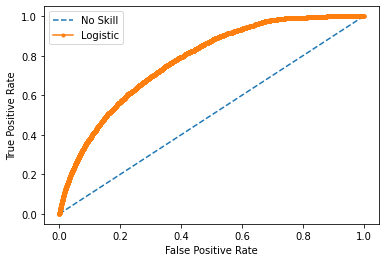

In [212]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(pred_result))]

# predict probabilities
lr_probs = pred_result

# keep probabilities for the positive outcome only
#lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(test[target].values, ns_probs)
lr_auc = roc_auc_score(test[target].values, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.2f' % (ns_auc))
print('Logistic: ROC AUC=%.2f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test[target].values, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test[target].values, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Recommend Hotel for a user

In [195]:
rows = []
hotel = list(df.drop_duplicates(subset='item_id', keep='first').item_id)
names = list(df.drop_duplicates(subset='item_id', keep='first').item_id)

for i in range(len(hotel)):
    rows.append( dict({'name': names[i], 'item_id' : hotel[i], 'user_id' : 1048}))
test_data = pd.DataFrame(rows)

In [198]:
for idx, (score, name) in enumerate(sorted(zip(pred_result, names), reverse=True)):
    if idx >= 5:
        break
 
    print("User_id 1048 recommended ", " hotel cluster: ", name)

User_id 1048 recommended   hotel cluster:  45
User_id 1048 recommended   hotel cluster:  17
User_id 1048 recommended   hotel cluster:  40
User_id 1048 recommended   hotel cluster:  11
User_id 1048 recommended   hotel cluster:  98


## Resources

https://arxiv.org/abs/1606.07792

https://github.com/shenweichen/DeepCTR

https://deepctr-doc.readthedocs.io/en/v0.3.1/deepctr.models.wdl.html

https://github.com/shenweichen/DeepCTR/blob/ce140ffcc1057e8fb57622ae1732c39df32bc11e/docs/source/FAQ.md

https://github.com/shenweichen/DeepCTR/blob/db229dc31f0d4c79c0de2ece0bb919b35258d6b2/examples/run_regression_movielens.py

https://github.com/shenweichen/DeepCTR/blob/db229dc31f0d4c79c0de2ece0bb919b35258d6b2/examples/run_multivalue_movielens.py

https://deepctr-doc.readthedocs.io/en/latest/Examples.html#classification-criteo

https://deepctr-doc.readthedocs.io/en/latest/Quick-Start.html